# Clenshawのアルゴリズム

Clenshawのアルゴリズム（Chebyshev補間のある点での関数値の評価）を説明して、実装する。

いま $n$ 次のチェビシェフ多項式で展開された関数の $x$ における値

$$
    S_n=\sum_{r=0}^n a_rP_r(x) = a_0P_0(x) + a_1P_1(x) + \dots + a_nP_n(x)
$$

の計算することを考える。ここで $\{P_r(x)\}$ はチェビシェフ多項式（第1〜4種）である。この $S_n$ は

$$ S_n=\mathbf{a}^{T}\mathbf{p} $$

と表すことができ、

$$ \mathbf{a}^{T}=(a_0,a_1,\dots,a_n),\quad\mathbf{p}=(P_0(x),\dots,P_n(x))^T. $$

それぞれ多項式は次のような再帰的関係式が成り立つ。

$$ P_r(x)-2xP_{r-1}(x)+P_{r-2}(x)=0,\quad r=2,3,\dots$$

それぞれ、

$$ P_0(x)=1,\quad P_1(x)=\begin{cases}T_1(x)=x & (\mbox{第１種チェビシェフ多項式})\\
U_1(x)=2x& (\mbox{第２種チェビシェフ多項式})\\
V_1(x)=2x-1& (\mbox{第３種チェビシェフ多項式})\\
W_1(x)=2x+1& (\mbox{第４種チェビシェフ多項式}).
\end{cases}$$

上の関係式は以下のように行列表記で表される。

$$
%\left(
\begin{pmatrix}%{cccccccc}
1 & & & & & & \\
-2 x & 1 & & & & & \\
1 & -2 x & 1 & & & & \\
& 1 & -2 x & 1 & & & \\
& & \ddots & \ddots & \ddots & & \\
& & & 1 & -2 x & 1 & \\
& & & & 1 & -2 x & 1
\end{pmatrix}\begin{pmatrix}
P_0(x)\\P_1(x)\\P_2(x)\\P_3(x)\\\vdots\\P_{n-1}(x)\\P_n(x)
\end{pmatrix}=\begin{pmatrix}
1\\X\\0\\0\\\vdots\\0\\0
\end{pmatrix}.
% \right)
$$



または、左辺の係数行列を $\mathbf{A}$ とすると次のようにも表記できる。

$$ \mathbf{A}\mathbf{p}=\mathbf{c},\quad
\mathbf{c}=
\begin{pmatrix}
1\\X\\0\\\vdots\\0
\end{pmatrix}. $$

ここでベクトル $\mathbf{c}$ 内の $X$ は、それぞれのチェビシェフ多項式（第1〜4種）に対応して $X=-x, 0, -1, 1$ である。さらに

$$ \mathbf{b}^T=(b_0,b_1,・・・,b_n) $$

は以下をみたすベクトルであるとする。

$$
%\left(
(b_0,b_1,...,b_n)
\begin{pmatrix}%{cccccccc}
1 & & & & & & \\
-2 x & 1 & & & & & \\
1 & -2 x & 1 & & & & \\
& 1 & -2 x & 1 & & & \\
& & \ddots & \ddots & \ddots & & \\
& & & 1 & -2 x & 1 & \\
& & & & 1 & -2 x & 1
\end{pmatrix}=(a_0,a_1,...,a_n)
% \right)
$$

これは次のようにも書ける。

$$ \mathbf{b}^{T}\mathbf{A}=\mathbf{a}^T. $$

よって、

$$ S_n=\mathbf{a}^{T}\mathbf{p}=\mathbf{b}^{T}\mathbf{A}\mathbf{p}=\mathbf{b}^{T}\mathbf{c}=b_0+b_{1}X. $$

このとき各 $b_r$ は $b_{n+1}=b_{n+2}=0$ を仮定すると、上の式から次の漸化式をみたす。

$$ b_r-2xb_{r+1}+b_{r+2}=a_r,\quad r=n,\dots,1,0. $$


よって、$b_{n+1}=b_{n+2}=0$を仮定し漸化式を逐次的に計算することで $S_n$ は計算できる。

$$ S_n=b_0+b_1X $$

これを**Clenshawのアルゴリズム**という。

ClenshawのアルゴリズムをJuliaで実装し、区間演算と組み合わせてチェビシェフ補間の関数値の精度保証付き数値計算を実行する。まず、上で説明した逐次的な反復計算を実行すると

In [1]:
versioninfo()

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.2.0)
  CPU: Apple M1 Max
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, cyclone)


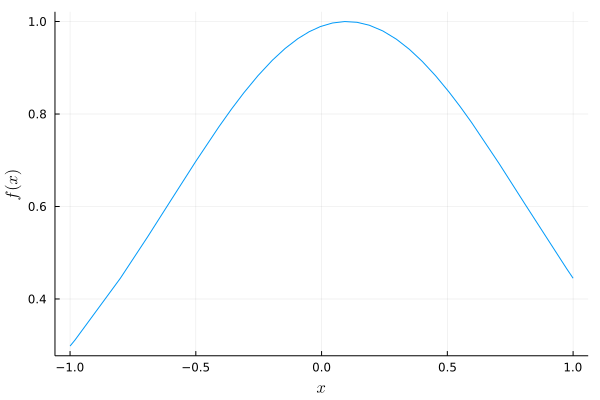

In [2]:
include("FourierChebyshev.jl")
f(x) = exp.(-(x.-0.1).^2)
using Plots
plot(f,-1,1,legend=false,xlabel="\$x\$",ylabel="\$f(x)\$")

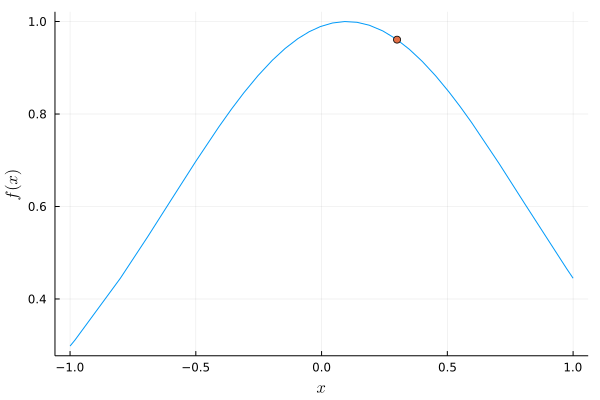

In [3]:
a = cheb(f); n = length(a) - 1
x = 0.3
bk0 = 0
bk1 = 0
for r = (n+1):-1:1
    tmp = 2x*bk0 - bk1 + a[r]
    bk1 = bk0
    bk0 = tmp
end
Sₙ = bk0 + bk1*(-x)
scatter!([x],[Sₙ])

上図は $f(x)=\exp\left(-(x-0.1)^2\right)$ の $x=0.3$ における値をプロットしている。

In [4]:
f(x) ≈ Sₙ

true

さらに反復計算の工夫により、反復回数を約半分にしたコードによってClenshawのアルゴリズムを実装する。

In [5]:
function clenshaw(a,x) # Clenshaw's algorithm
# a: (Two-sided) Chbyshev coefficients
# x: evaluating points
    n = length(a)-1
    bk1 = 0.0
    bk2 = 0.0
    x = 2x
    for r = (n+1):-2:3
        bk2 = x.*bk1 .- bk2 .+ a[r]
        bk1 = x.*bk2 .- bk1 .+ a[r-1]
    end
    if isodd(n)        
        b2 = x.*bk1 .- bk2 .+ a[2]
        bk2 = bk1 # b3
        bk1 = b2
    end
    return -bk2 .+ 0.5x .* bk1 .+ a[1] # y = c(1) + .5*x.*bk1 - bk2;
end

clenshaw (generic function with 1 method)

実際に、$x=0.3, 0.5$ における関数値をClenshawのアルゴリズムとJuliaの関数値で計算すると同程度の値が計算されている。

In [6]:
clenshaw(a,[0.3,0.5])

2-element Vector{Float64}:
 0.9607894391523228
 0.8521437889662121

In [7]:
f([0.3,0.5])

2-element Vector{Float64}:
 0.9607894391523232
 0.8521437889662113

一方で、第1種チェビシェフ多項式の定義

$$
 T_n(x):=\cos(n\theta),\quad x=\cos(\theta)
$$

から、以下のように関数値を計算する方法も実装できる。

In [8]:
function eval_cheb(ChebCoeffs_twosided,x)
    M = length(ChebCoeffs_twosided) # M: size of chebyshev
    k = 0:M-1
    return cos.(Vector(k)' .* acos.(x)) * ChebCoeffs_twosided
end

eval_cheb (generic function with 1 method)

In [9]:
eval_cheb(a,[0.3,0.5])

2-element Vector{Float64}:
 0.9607894391523226
 0.8521437889662123

これらの実装を計算時間の観点から比べてみる。はじめに多くの点（100万点）で関数値を計算すると、

In [10]:
using BenchmarkTools
x = rand(1000000);
@btime clenshaw($a,$x);
@btime eval_cheb($a,$x);

  15.952 ms (213 allocations: 198.37 MiB)
  727.821 ms (5 allocations: 183.11 MiB)


計算の実行時間で約40倍`clenshaw`のアルゴリズムが早いことが分かる。次に区間演算を用いて計算した関数値を区間で包含する計算時間を比べると

In [11]:
using IntervalArithmetic
x = map(Interval,rand(10000));
@btime clenshaw($a,$x);
@btime eval_cheb($a,$x);

  14.533 ms (120213 allocations: 6.42 MiB)
  63.371 ms (1320005 allocations: 23.80 MiB)


こちらも`clenshaw`のアルゴリズムの実装の方が計算時間が早い。

一方で、チェビシェフ補間の項数が多くなってくると`clenshaw`のアルゴリズム内で区間演算を実行する回数が多くなり、区間の幅が増大することが観測される。

In [12]:
f(x) = 1/(1+1000*(x+.5)^2)+1/sqrt(1+1000*(x-.5)^2)
# f(x) = exp(x)
# using SpecialFunctions
# f(x) = exp(erf(x^2)+x.^5).*sin(3*pi*x) + x
a = cheb(f)
ix = interval.(rand(100))
Sn = clenshaw(a,ix)
@show maximum(radius,Sn) # Clenshaw's algorithm
Sn = eval_cheb(a,ix)
@show maximum(radius,Sn); # naive implementation

maximum(radius, Sn) = 8.803944422526876e283
maximum(radius, Sn) = 5.0737192225369654e-14


したがって、これらの計測から分かる**区間演算を利用した関数値の包含に対するベストプラクティス**はチェビシェフ補間の項数が少ない場合（大体20項程度まで）は`Clenshaw`のアルゴリズムによる評価を利用し、それ以降は`eval_cheb`の計算方法を採用することが良いと思われる。

本資料は以下のような文献・Web ページ等を参考にこの文章は書いています。


**参考文献**
1.  J.C. Mason and D.C. Handscomb, Chebyshev Polynomials (1st ed.), Chapman and Hall/CRC, 2002.<br>
(2.4.1章にClenshawのアルゴリズムの説明があり、それのほぼ和訳になっている。この本はチェビシェフ多項式をもの凄く詳しく説明している教科書で辞書的に調べる使い方で無敵を誇る)

<div align="right">二平泰知, <a href="http://www.risk.tsukuba.ac.jp/~takitoshi/">高安亮紀</a>，2022年8月4日</div>